In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error



In [2]:
df = pd.read_csv("./datasets/uber_9_10.csv")
df.head()


,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
1,27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
2,44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1
3,25894730,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3
4,17610152,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5


In [3]:
print(df.info())
print(df.describe())
print(df.isnull().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Unnamed: 0         200000 non-null  int64  
 1   key                200000 non-null  object 
 2   fare_amount        200000 non-null  float64
 3   pickup_datetime    200000 non-null  object 
 4   pickup_longitude   200000 non-null  float64
 5   pickup_latitude    200000 non-null  float64
 6   dropoff_longitude  199999 non-null  float64
 7   dropoff_latitude   199999 non-null  float64
 8   passenger_count    200000 non-null  int64  
dtypes: float64(5), int64(2), object(2)
memory usage: 13.7+ MB
None
         Unnamed: 0    fare_amount  pickup_longitude  pickup_latitude  \
count  2.000000e+05  200000.000000     200000.000000    200000.000000   
mean   2.771250e+07      11.359955        -72.527638        39.935885   
std    1.601382e+07       9.901776         11.437787         7.7

In [4]:
# Drop rows with missing or invalid values
df = df.dropna()

# Remove obviously wrong coordinates (outside NYC)
df = df[(df['pickup_longitude'] > -80) & (df['pickup_longitude'] < -70)]
df = df[(df['dropoff_longitude'] > -80) & (df['dropoff_longitude'] < -70)]
df = df[(df['pickup_latitude'] > 35) & (df['pickup_latitude'] < 45)]
df = df[(df['dropoff_latitude'] > 35) & (df['dropoff_latitude'] < 45)]

# Remove impossible fare values
df = df[(df['fare_amount'] > 0) & (df['fare_amount'] < 100)]
df.head()


,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
1,27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
2,44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1
3,25894730,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3
4,17610152,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5


In [5]:
# Convert datetime column to datetime type
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'], errors='coerce')

# Extract useful time-based features
df['hour'] = df['pickup_datetime'].dt.hour
df['day'] = df['pickup_datetime'].dt.day
df['month'] = df['pickup_datetime'].dt.month
df['year'] = df['pickup_datetime'].dt.year

# Haversine distance between pickup and dropoff (approximate)
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # radius of Earth in km
    phi1, phi2 = np.radians(lat1), np.radians(lat2)
    dphi = np.radians(lat2 - lat1)
    dlambda = np.radians(lon2 - lon1)
    a = np.sin(dphi/2)**2 + np.cos(phi1)*np.cos(phi2)*np.sin(dlambda/2)**2
    return 2 * R * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

df['distance_km'] = haversine(df['pickup_latitude'], df['pickup_longitude'],
                              df['dropoff_latitude'], df['dropoff_longitude'])

df = df[df['distance_km'] > 0]
df.head()

,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,hour,day,month,year,distance_km
0,24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06+00:00,-73.999817,40.738354,-73.999512,40.723217,1,19,7,5,2015,1.683323
1,27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56+00:00,-73.994355,40.728225,-73.994710,40.750325,1,20,17,7,2009,2.457590
2,44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00+00:00,-74.005043,40.740770,-73.962565,40.772647,1,21,24,8,2009,5.036377
3,25894730,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21+00:00,-73.976124,40.790844,-73.965316,40.803349,3,8,26,6,2009,1.661683
4,17610152,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00+00:00,-73.925023,40.744085,-73.973082,40.761247,5,17,28,8,2014,4.475450


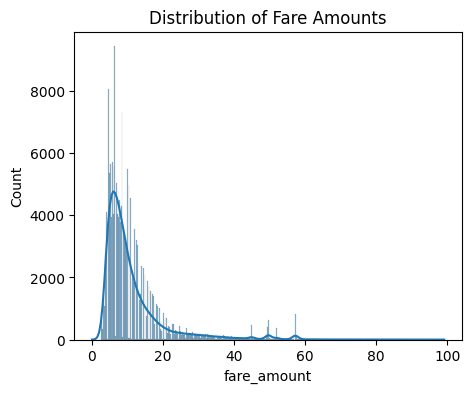

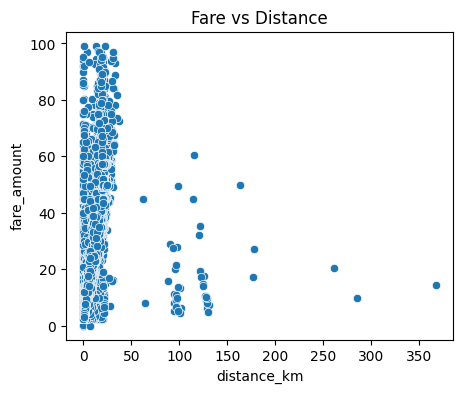

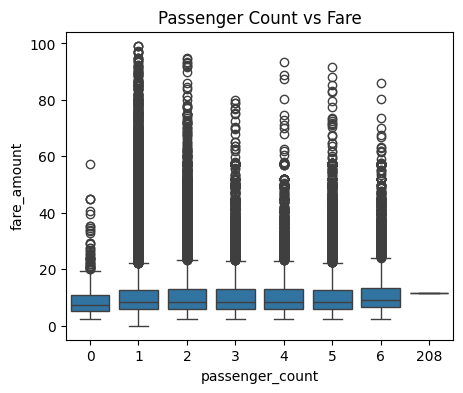

In [6]:
plt.figure(figsize=(5,4))
sns.histplot(df['fare_amount'], kde=True)
plt.title("Distribution of Fare Amounts")
plt.show()

plt.figure(figsize=(5,4))
sns.scatterplot(x='distance_km', y='fare_amount', data=df)
plt.title("Fare vs Distance")
plt.show()

plt.figure(figsize=(5,4))
sns.boxplot(x='passenger_count', y='fare_amount', data=df)
plt.title("Passenger Count vs Fare")
plt.show()

In [7]:
X = df[['pickup_longitude','pickup_latitude','dropoff_longitude',
        'dropoff_latitude','passenger_count','distance_km','hour','day','month','year']]
y = df['fare_amount']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
y_pred = lr.predict(X_test_scaled)

print("R² without PCA:", r2_score(y_test, y_pred))
print("RMSE without PCA:", np.sqrt(mean_squared_error(y_test, y_pred)))


R² without PCA: 0.5615627596951531
RMSE without PCA: 6.142378948053369


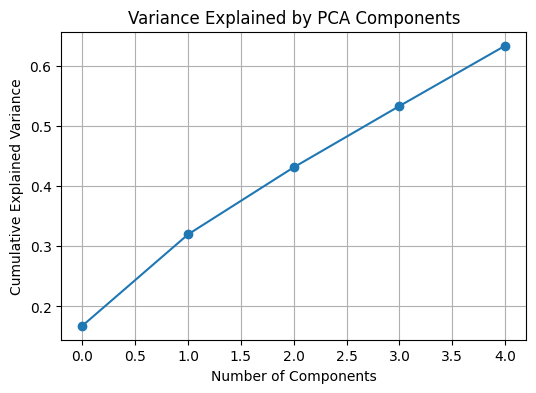

Explained variance ratio: [0.16800207 0.15195853 0.11158451 0.10192809 0.10030842]
Total variance preserved: 0.6337816140626175


In [8]:
pca = PCA(n_components=5)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)


plt.figure(figsize=(6,4))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Variance Explained by PCA Components')
plt.grid(True)
plt.show()


print("Explained variance ratio:", pca.explained_variance_ratio_)
print("Total variance preserved:", sum(pca.explained_variance_ratio_))


In [9]:
lr_pca = LinearRegression()
lr_pca.fit(X_train_pca, y_train)
y_pred_pca = lr_pca.predict(X_test_pca)

print("R² with PCA:", r2_score(y_test, y_pred_pca))
print("RMSE with PCA:", np.sqrt(mean_squared_error(y_test, y_pred_pca)))


R² with PCA: 0.47355972504647903
RMSE with PCA: 6.730656738203196


         Model        R2      RMSE
0  Without PCA  0.561563  6.142379
1     With PCA  0.473560  6.730657


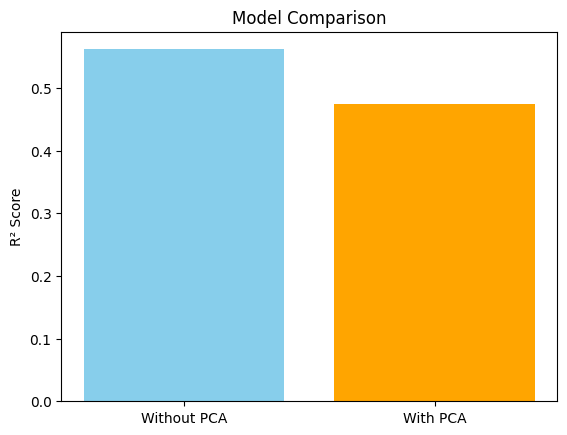

In [10]:
results = pd.DataFrame({
    "Model":["Without PCA","With PCA"],
    "R2":[r2_score(y_test, y_pred), r2_score(y_test, y_pred_pca)],
    "RMSE":[np.sqrt(mean_squared_error(y_test, y_pred)),
            np.sqrt(mean_squared_error(y_test, y_pred_pca))]
})

print(results)

plt.bar(results["Model"], results["R2"], color=['skyblue','orange'])
plt.ylabel("R² Score")
plt.title("Model Comparison")
plt.show()